# Details

**Notebook to check results** 
- Baselines (ZeroShot, Linear Probe)
- CoOp
- CoCoOp
- CLIP Adapters

# Installs, Imports, Preps

In [1]:
%%capture
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers
!pip install yacs

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Start Execution 

In [1]:
cd /content/drive/Shareddrives/cis630/CoOp/code

/content/drive/Shareddrives/cis630/CoOp/code


Device

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"

In [3]:
from torch.utils.data import DataLoader, Subset, TensorDataset

**CLIP Model**

In [4]:
from utils import build_lr_scheduler
from config import get_cfg_defaults
cfg = get_cfg_defaults()

In [5]:
from CustomCLIPCoOp import CustomCLIPCoOp
from Dataset import *
from TrainCode import *
from CustomCLIPCoCoOp import CustomCLIPCoCoOp

In [6]:
import clip
print(f"Loading {cfg.MODEL.NAME}")
clip_model, transform = clip.load(cfg.MODEL.NAME)
clip_model.to(device)
print(f"Model in {device}")

Loading RN50
Model in cuda


****

#Data Read

(data set up in another notebook)

In [8]:
cfg.DATASET.NAME

'dtd'

In [9]:
img_embs = torch.load(f'/content/drive/Shareddrives/cis630/CoOp/checkpoints/{cfg.DATASET.NAME}_image_embs.pt')
lbls = torch.load(f'/content/drive/Shareddrives/cis630/CoOp/checkpoints/{cfg.DATASET.NAME}_labels.pt')

img_embs.shape,lbls.shape

(torch.Size([564, 1024]), torch.Size([564]))

### Isolate some classes

In [ ]:
index = torch.where(lbls>=99)[0]
test_img, test_lbl = img_embs[index], lbls[index]

In [ ]:
index = torch.where(lbls<99)[0]
train_img, train_lbl = img_embs[index], lbls[index]

In [ ]:
nshots = [1,2,4,8]

train_set,_, _  =  subset_data(train_img,train_lbl,
                                               nshot = nshots,
                                               test_size = 2,
                                               n_classes = len(cfg.DATASET.CLASSNAMES)-3,
                                               per_class=10)

test_img_emb,test_label = test_img, test_lbl

# Check Results

Plot the results 

### Zero Shot

Zero shot perofrmance of CLIP

In [12]:
prompt = "{} texture."
text_class = [prompt.format(i) for i in cfg.DATASET.CLASSNAMES]

input = clip.tokenize(text_class).to(device)
text_emb = clip_model.encode_text(input)
print(text_emb.shape)

train_dataloader = DataLoader(TensorDataset(img_embs,lbls), 
           batch_size=32, shuffle=False)

torch.Size([47, 1024])


In [13]:
zero_shot = zeroShot(train_dataloader,clip_model,text_emb)

100%|██████████| 18/18 [00:00<00:00, 333.92it/s]



Accuracy:  0.421875 
F1-score:  0.1429257557915239


### Linear Probe + CoOp

for different n-shots implement Linear-Probe and CoOp

In [25]:
nshots = [1,2,4,8]

linear_probe = {1:[],2:[],4:[],8:[]}
coop = {1:[],2:[],4:[],8:[]}
coop_c = {1:[],2:[],4:[],8:[]}
# cocoop = []

for _ in range(3):
  train_set,test_img_emb, test_label  =  subset_data(img_embs,lbls,
                                              nshot = nshots,
                                              test_size = 2,
                                              n_classes = len(cfg.DATASET.CLASSNAMES),
                                              per_class=10)
  for nshot in nshots:
    print('_'*40,'\n')
    print(f"Considering n-shot = {nshot}\n")

    '''Linear Probe'''
    print("\t\t\tBaseline: Linear Probe")
    train_img_emb, train_label = train_set[nshot]
    acc = logistic(train_img_emb.detach().cpu().numpy(),
              train_label.detach().cpu().numpy(),
              test_img_emb.detach().cpu().numpy(),
              test_label.detach().cpu().numpy())
    
    linear_probe[nshot].append(acc)
    
    '''CoOp'''
    print("\t\t\tCoOp")

    # model init
    model = CustomCLIPCoOp(cfg, clip.load(cfg.MODEL.NAME)[0],device)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.SGD(model.prompt_learner.parameters(), lr=cfg.OPTIM.LR)
    scheduler = build_lr_scheduler(optimizer, cfg.OPTIM)

    # train
    train_img_emb, train_label = train_set[nshot]
    print()
    train_dataloader = torch.utils.data.DataLoader(TensorDataset(train_img_emb.detach(),train_label), batch_size=6*nshot, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(TensorDataset(test_img_emb.detach(),test_label), batch_size=6, shuffle=False)

    acc = train(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, n_epoch=30)

    coop[nshot].append(acc)
    del(model)

    '''CoCoOp'''
    print("\t\t\tCoCoOp")

    # model init
    model = CustomCLIPCoCoOp(cfg, clip.load(cfg.MODEL.NAME)[0],device)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.SGD(model.prompt_learner.parameters(), lr=cfg.OPTIM.LR)
    scheduler = build_lr_scheduler(optimizer, cfg.OPTIM)

    # train
    train_img_emb, train_label = train_set[nshot]
    print()
    train_dataloader = torch.utils.data.DataLoader(TensorDataset(train_img_emb.detach(),train_label), batch_size=4, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(TensorDataset(test_img_emb.detach(),test_label), batch_size=4, shuffle=False)

    acc = train(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, n_epoch=30)

    cocoop.append(acc)

In [ ]:
linear_probe = [np.mean(linear_probe[k]) for k,v in linear_probe.items()]
coop = [np.mean(coop[k]) for k,v in coop.items()]

### Context

How does result vary with changing context sizes

In [ ]:
train_img_emb,train_label,test_img_emb,test_label  =  subset_data(img_embs,lbls,
                                               nshot = 4,
                                               test_size = 2,
                                               n_classes = len(cfg.DATASET.CLASSNAMES),
                                               per_class=10)

coop = []
ctx_size = [4,8,16,32]
nshot=4

for ct in ctx_size:
  print('_'*40,'\n')
  '''CoOp'''
  print("\t\t\tCoOp")
  cfg.TRAIN.N_CTX = ct

  # model init
  model = CustomCLIPCoOp(cfg, clip.load(cfg.MODEL.NAME)[0],device)
  model.to(device)
  criterion = torch.nn.CrossEntropyLoss(reduction='sum')
  optimizer = torch.optim.SGD(model.prompt_learner.parameters(), lr=cfg.OPTIM.LR)
  scheduler = build_lr_scheduler(optimizer, cfg.OPTIM)

  print()
  train_dataloader = torch.utils.data.DataLoader(TensorDataset(train_img_emb.detach(),train_label), batch_size=6*nshot, shuffle=True)
  test_dataloader = torch.utils.data.DataLoader(TensorDataset(test_img_emb.detach(),test_label), batch_size=6, shuffle=False)

  acc = train(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, n_epoch=30)

  coop.append(acc)
  del(model)

# Plots

Different results for study

### Flower

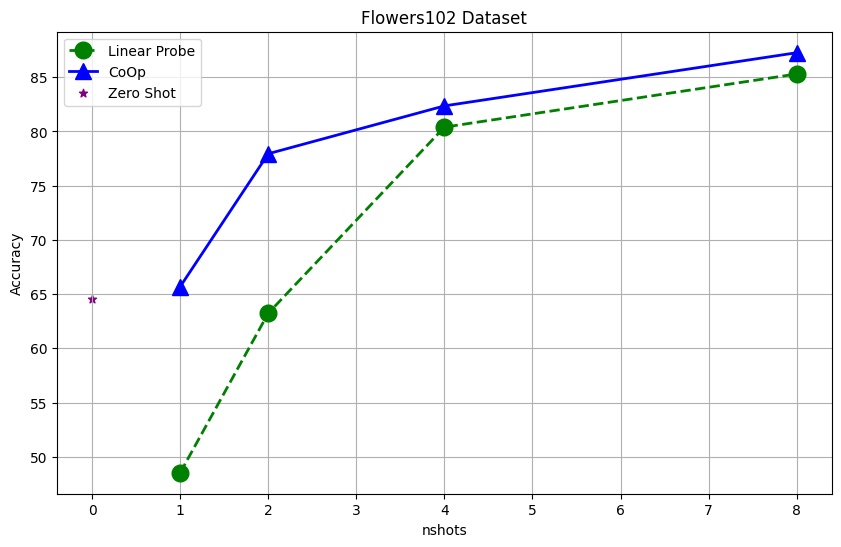

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(nshots,np.array(linear_probe)*100, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12,label="Linear Probe")
plt.plot(nshots,coop, color='blue', marker="^", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.scatter([0],zero_shot*100,color='purple',marker="*",label="Zero Shot")
plt.legend()
plt.title('Flowers102 Dataset')
plt.ylabel('Accuracy')
plt.xlabel('nshots')
plt.grid()
plt.show()

Flower-vit32

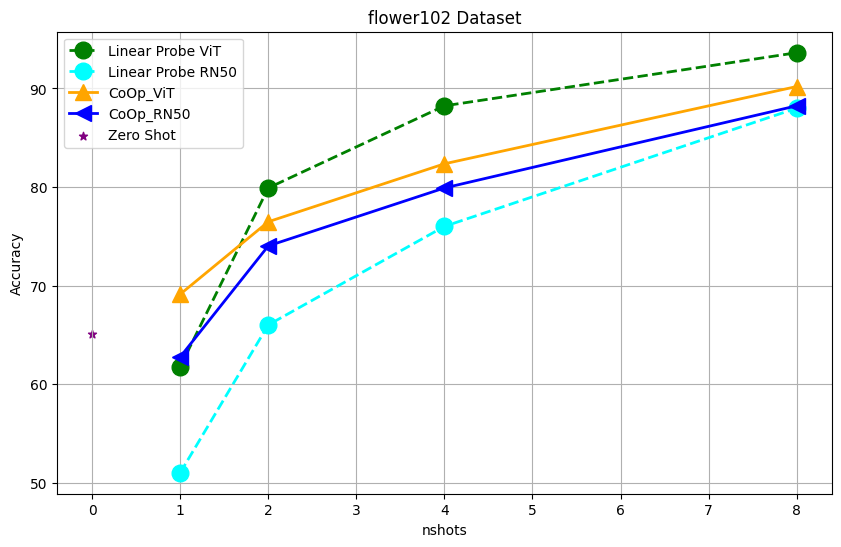

In [ ]:
old_linear_probe = [51,66,76,88]
old = [62.75, 74.02,79.9,88.24]

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(nshots,linear_probe, color='g', marker='o', linestyle='dashed',linewidth=2, markersize=12,label="Linear Probe ViT")
plt.plot(nshots,old_linear_probe, color='cyan', marker='o', linestyle='dashed',linewidth=2, markersize=12,label="Linear Probe RN50")
plt.plot(nshots,coop, color='orange', marker="^", linestyle='solid',linewidth=2, markersize=12,label="CoOp_ViT")
plt.plot(nshots,old, color='blue', marker="<", linestyle='solid',linewidth=2, markersize=12,label="CoOp_RN50")
plt.scatter([0],zero_shot*100,color='purple',marker="*",label="Zero Shot")
plt.legend()
plt.title(f'{cfg.DATASET.NAME} Dataset')
plt.ylabel('Accuracy')
plt.xlabel('nshots')
plt.grid()
plt.show()

Flower COCoOp Unseen

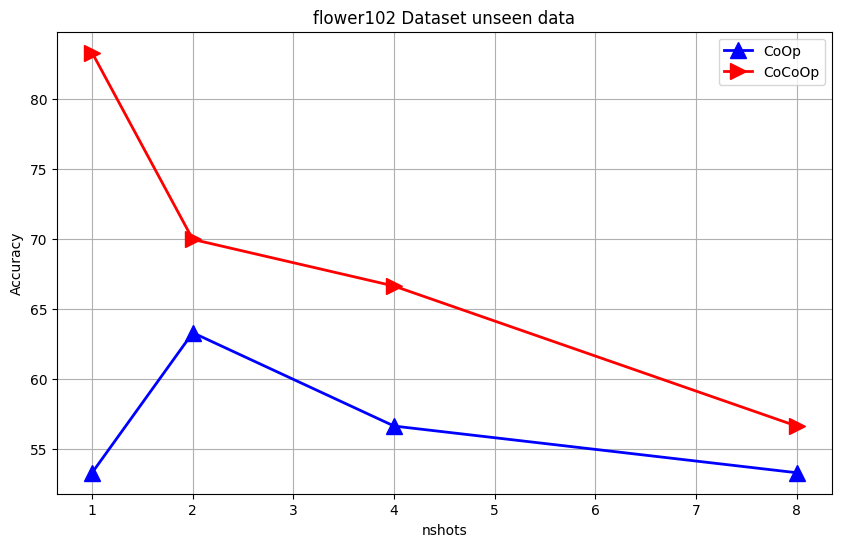

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(nshots,coop, color='blue', marker="^", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.plot(nshots,cocoop, color='red', marker=">", linestyle='solid',linewidth=2, markersize=12,label="CoCoOp")
plt.legend()
plt.title(f'{cfg.DATASET.NAME} Dataset unseen data')
plt.ylabel('Accuracy')
plt.xlabel('nshots')
plt.grid()
plt.show()

Context Size

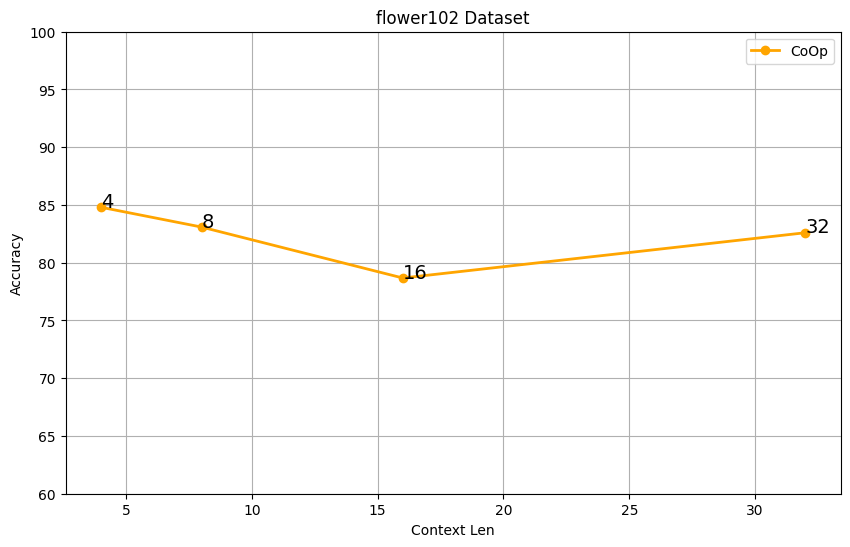

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot([4,8,16,32],coop, color='orange', marker=".", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.text(4, coop[0], "4",fontsize=14)
plt.text(8, coop[1], "8",fontsize=14)
plt.text(16, coop[2], "16",fontsize=14)
plt.text(32, coop[3], "32",fontsize=14)
plt.legend()
plt.title(f'{cfg.DATASET.NAME} Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Context Len')
plt.ylim(60,100)
plt.grid()
plt.show()

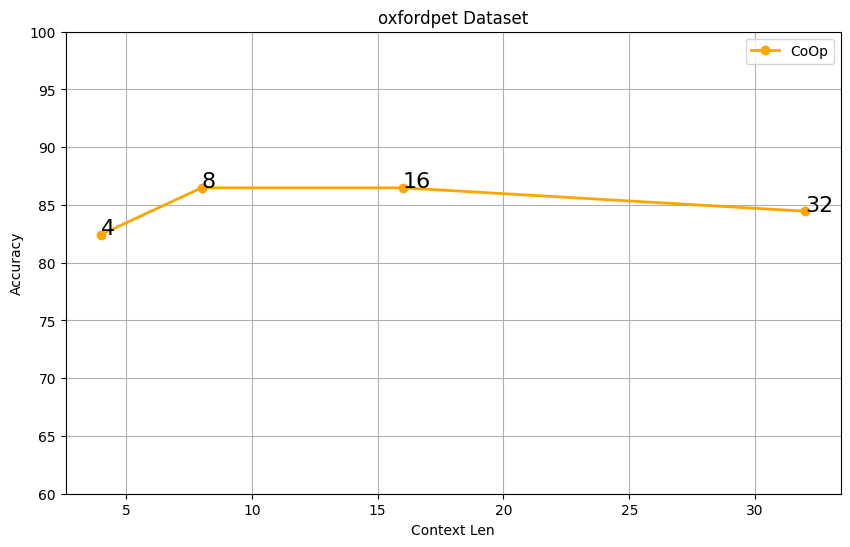

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot([4,8,16,32],coop, color='orange', marker=".", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.text(4, coop[0], "4",fontsize=16)
plt.text(8, coop[1], "8",fontsize=16)
plt.text(16, coop[2], "16",fontsize=16)
plt.text(32, coop[3], "32",fontsize=16)
plt.legend()
plt.title(f'oxfordpet Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Context Len')
plt.ylim(60,100)
plt.grid()
plt.show()

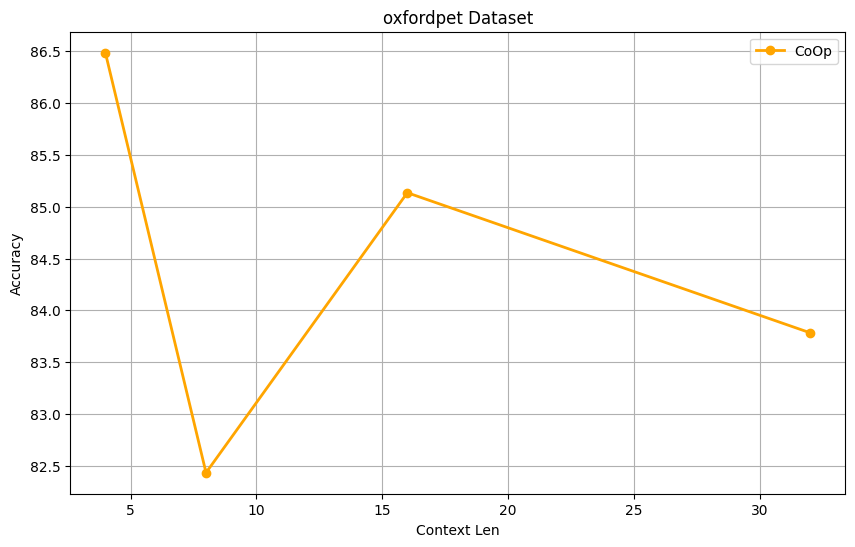

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot([4,8,16,32],coop, color='orange', marker=".", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.text(4, coop[0], "4",fontsize=16)
plt.text(8, coop[1], "8",fontsize=16)
plt.text(16, coop[2], "16",fontsize=16)
plt.text(32, coop[3], "32",fontsize=16)
plt.legend()
plt.title(f'{cfg.DATASET.NAME} Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Context Len')
plt.grid()
plt.show()

### OxfordPet

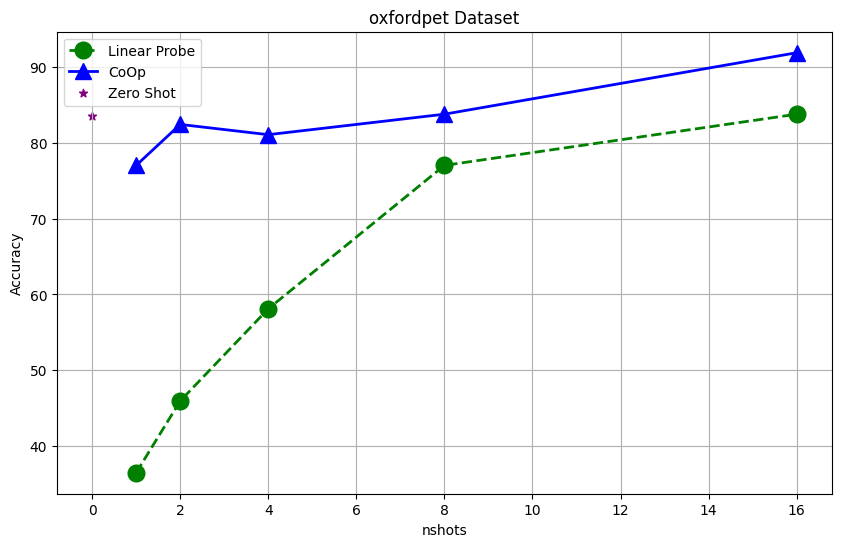

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(nshots,linear_probe, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12,label="Linear Probe")
plt.plot(nshots,coop, color='blue', marker="^", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.scatter([0],zero_shot*100,color='purple',marker="*",label="Zero Shot")
plt.legend()
plt.title(f'{cfg.DATASET.NAME} Dataset')
plt.ylabel('Accuracy')
plt.xlabel('nshots')
plt.grid()
plt.show()

### DTD

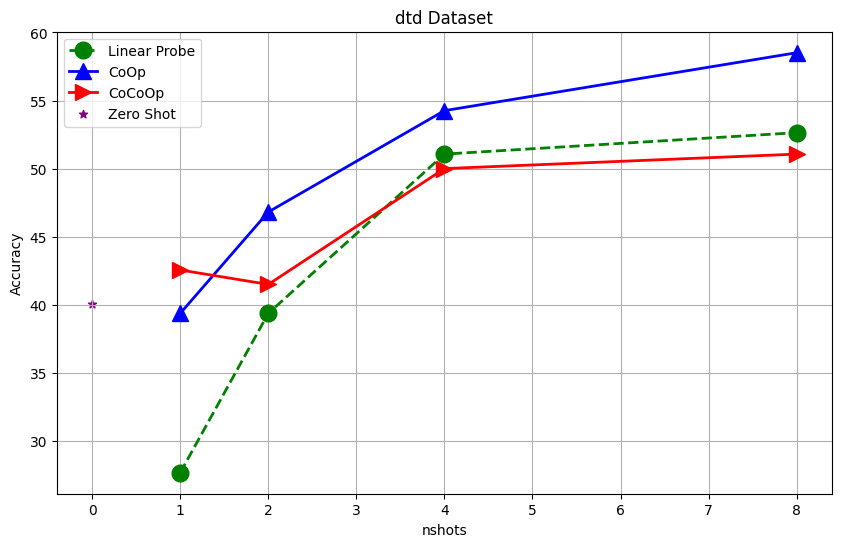

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(nshots,linear_probe, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12,label="Linear Probe")
plt.plot(nshots,coop, color='blue', marker="^", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.plot(nshots,cocoop, color='red', marker=">", linestyle='solid',linewidth=2, markersize=12,label="CoCoOp")
plt.scatter([0],zero_shot*100,color='purple',marker="*",label="Zero Shot")
plt.legend()
plt.title(f'{cfg.DATASET.NAME} Dataset')
plt.ylabel('Accuracy')
plt.xlabel('nshots')
plt.grid()
plt.show()

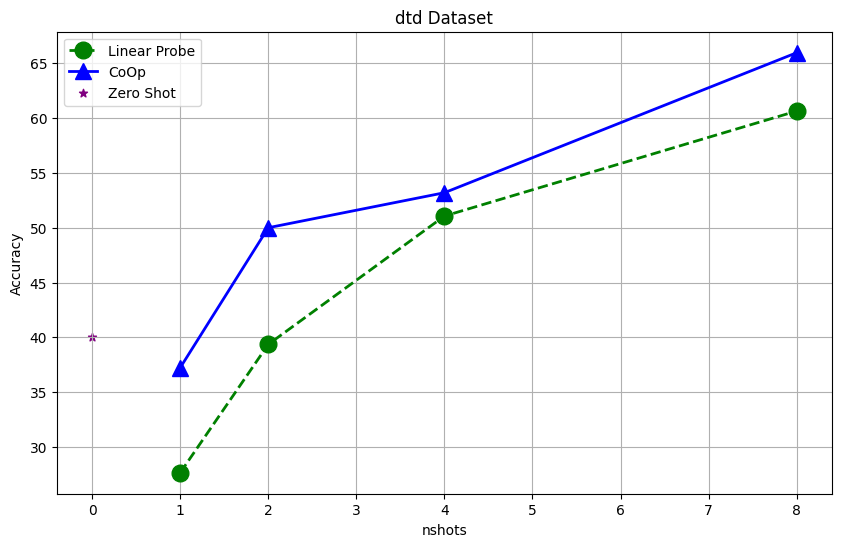

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(nshots,linear_probe, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12,label="Linear Probe")
plt.plot(nshots,coop, color='blue', marker="^", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.scatter([0],zero_shot*100,color='purple',marker="*",label="Zero Shot")
plt.legend()
plt.title(f'{cfg.DATASET.NAME} Dataset')
plt.ylabel('Accuracy')
plt.xlabel('nshots')
plt.grid()
plt.show()

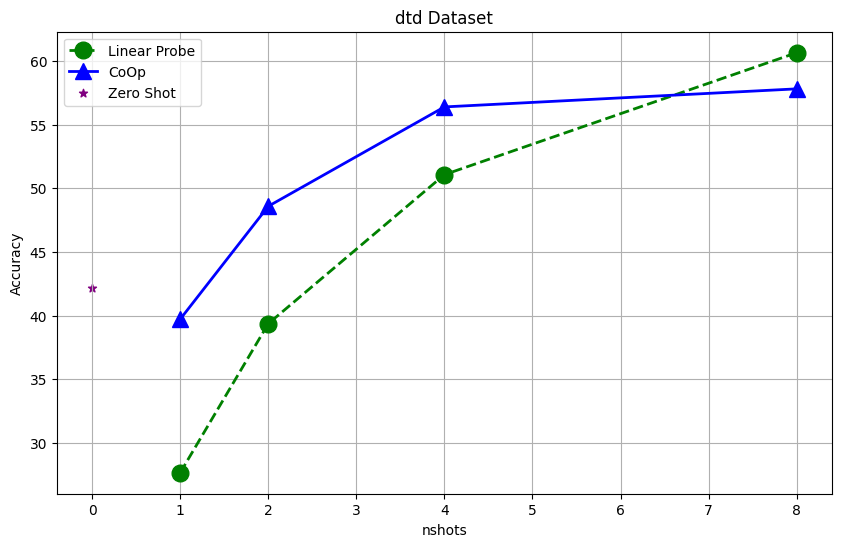

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(nshots,linear_probe, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12,label="Linear Probe")
plt.plot(nshots,coop, color='blue', marker="^", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.scatter([0],zero_shot*100,color='purple',marker="*",label="Zero Shot")
plt.legend()
plt.title(f'{cfg.DATASET.NAME} Dataset')
plt.ylabel('Accuracy')
plt.xlabel('nshots')
plt.grid()
plt.show()

### FOOD

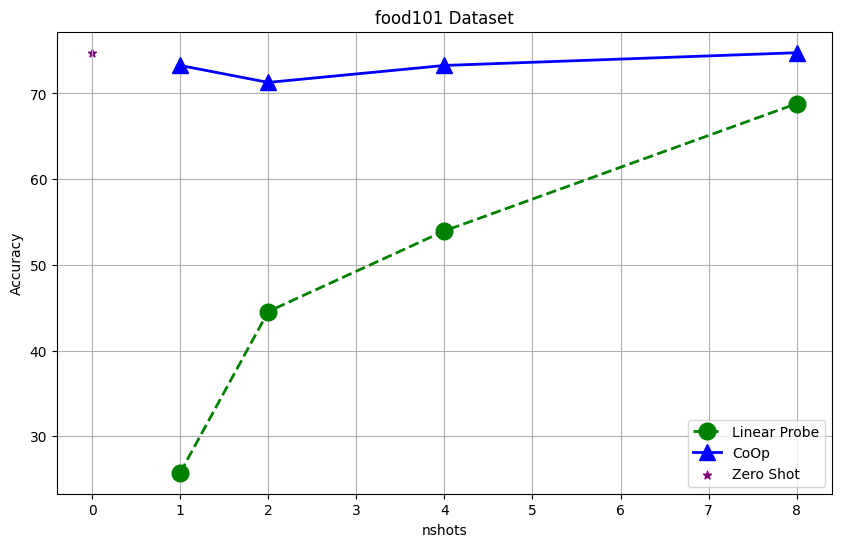

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(nshots,linear_probe, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12,label="Linear Probe")
plt.plot(nshots,coop, color='blue', marker="^", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.scatter([0],zero_shot*100,color='purple',marker="*",label="Zero Shot")
plt.legend()
plt.title(f'{cfg.DATASET.NAME} Dataset')
plt.ylabel('Accuracy')
plt.xlabel('nshots')
plt.grid()
plt.show()

# CLIP Adapter

Linear Probe + CoOp + CLIPAdapter

Check performance of CLIP Adapter vs CoOp

In [ ]:
from CustomCLIPAdapter import CustomCLIPAdapter
import time

In [ ]:
nshots = [1,2,4,8]

train_set,test_img_emb, test_label  =  subset_data(img_embs,lbls,
                                               nshot = nshots,
                                               test_size = 2,
                                               n_classes = len(cfg.DATASET.CLASSNAMES),
                                               per_class=10)

coop = []
adp = []
coop_time = []
adp_time = []

for nshot in nshots:
  print('\n',"-"*20, f"nshot: {nshot}","-"*20)
  train_img_emb, train_label = train_set[nshot]
  print()
  train_dataloader = torch.utils.data.DataLoader(TensorDataset(train_img_emb.detach(),train_label), batch_size=6*nshot, shuffle=True)
  test_dataloader = torch.utils.data.DataLoader(TensorDataset(test_img_emb.detach(),test_label), batch_size=6, shuffle=False)

  print("-"*20, "CLIP Adapter","-"*20)
  start = time.time()
  model = CustomCLIPAdapter(cfg, clip.load(cfg.MODEL.NAME)[0],device)
  model.to(device)
  criterion = torch.nn.CrossEntropyLoss(reduction='sum')
  optimizer = torch.optim.SGD(model.adapter.parameters(), lr=cfg.OPTIM.LR)
  scheduler = build_lr_scheduler(optimizer, cfg.OPTIM)
  acc = train(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, n_epoch=30)
  end = time.time()

  adp.append(acc)
  del(model)
  adp_time.append(end-start)

  print("-"*20, "CLIP CoOp","-"*20)
  # model init
  start = time.time()
  model = CustomCLIPCoOp(cfg, clip.load(cfg.MODEL.NAME)[0],device)
  model.to(device)
  criterion = torch.nn.CrossEntropyLoss(reduction='sum')
  optimizer = torch.optim.SGD(model.prompt_learner.parameters(), lr=cfg.OPTIM.LR)
  scheduler = build_lr_scheduler(optimizer, cfg.OPTIM)
  acc = train(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, n_epoch=30)
  end = time.time()

  coop.append(acc)
  del(model)
  coop_time.append(end-start)

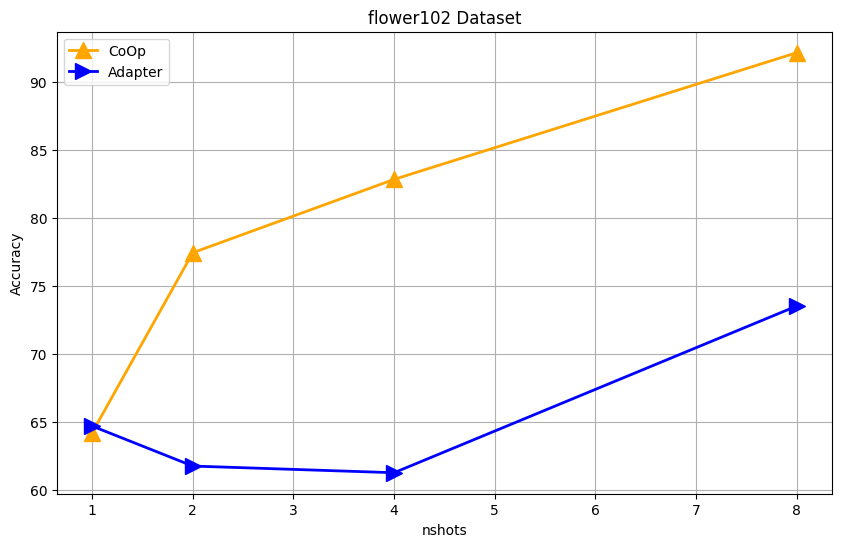

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(nshots,coop, color='orange', marker="^", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.plot(nshots,adp, color='blue', marker=">", linestyle='solid',linewidth=2, markersize=12,label="Adapter")
plt.legend()
plt.title(f'{cfg.DATASET.NAME} Dataset')
plt.ylabel('Accuracy')
plt.xlabel('nshots')
plt.grid()
plt.show()

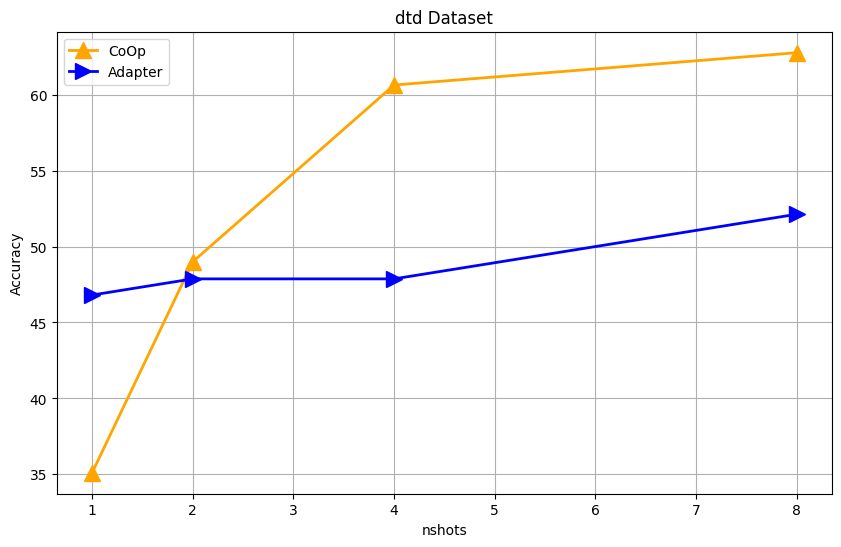

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(nshots,coop, color='orange', marker="^", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.plot(nshots,adp, color='blue', marker=">", linestyle='solid',linewidth=2, markersize=12,label="Adapter")
plt.legend()
plt.title(f'{cfg.DATASET.NAME} Dataset')
plt.ylabel('Accuracy')
plt.xlabel('nshots')
plt.grid()
plt.show()